#  How do collision-related variables and spatial factors, such as points of interest, affect the severity and risk of urban traffic accidents?

## Preparation

- [Github link](https://github.com/iantsern-twuk/twuk-CASA0006_Data-Science-for-Spatial-Systems.git) *[Optional]*

- Number of words: 1463

- Runtime: 0.02 hours (*Memory 32 GB, CPU Apple M3 Pro chip with 12 cores*)

- Coding environment: VS Code with Python 3.12.9 and Jupyter Notebook

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **H3**: A hexagonal hierarchical geospatial indexing system.
    - **sentence_transformers**: A model for semantic analysis matching text to vector space.

## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction
This research investigates the relationship between collision attributes and accident severity in urban environments. We examine temporal patterns, road classification, junction design, and weather conditions to understand their impact on crash outcomes. The analysis applies the Accident Risk Index (ARI) proposed by Jin and Noh (2023), computed within H3 hexagonal spatial grids to standardise geospatial representation.

To capture urban context, we incorporate point-of-interest (POI) data including commercial, recreational, and public locations, building on the framework of Brühwiler et al. (2022). Collision and POI data are preprocessed into consistent H3 formats, enabling spatial, temporal and mutiple feature analysis of accident severity.

We assess feature importance using SHapley Additive exPlanations (SHAP), following recent advances in interpretable machine learning in traffic safety research such as ramdem forest and xgboost (Ahmed et al., 2023; Rifat et al., 2024). This approach identifies the most influential predictors of accident severity across diverse conditions.

Ultimately, the model is applied to other cities to evaluate its predictive performance and assess its ability to generalise beyond the original study area.

[[ go back to the top ]](#Table-of-contents)

In [4]:
# ===== CORE GEOSPATIAL PROCESSING =====
import geopandas as gpd            # GeoPandas for vector geospatial data operations
from geopandas import GeoDataFrame # Specific class import (redundant with import gpd)
import shapely                     # Geometric operations library
from shapely.geometry import Point # Point object for creating point geometries
from shapely.geometry import mapping # Convert geometries to GeoJSON format
from shapely.ops import unary_union # Merge multiple geometries into one
import rtree                       # Spatial indexing for faster geographic queries
import h3                          # H3 hexagonal hierarchical geospatial indexing system
import h3.api.numpy_int            # NumPy integration for H3 (consider updating to newer h3 API)
import osmnx as ox                 # OpenStreetMap network data retrieval and analysis

# ===== DATA MANIPULATION =====
import pandas as pd                # DataFrame operations (imported twice - redundant)
import numpy as np                 # Numerical operations
import xarray as xr                # N-D labeled arrays and datasets (useful for raster data)
import json                        # JSON parsing and creation

# ===== VISUALIZATION =====
import matplotlib                  # Base plotting library
import matplotlib.pyplot as plt    # Pyplot interface (imported twice - redundant)
import matplotlib.colors as mcolors
import contextily as ctx           # Add basemaps to matplotlib plots
import folium                      # Interactive web maps
from branca.colormap import LinearColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from folium.plugins import HeatMap
import jenkspy
import html

# ===== MACHINE LEARNING & NLP =====
from sentence_transformers import SentenceTransformer  # Text embeddings for semantic analysis
from sklearn.metrics.pairwise import cosine_similarity # Measuring similarity between embeddings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold

# ===== UTILITIES =====
import warnings                    # Warning management
warnings.filterwarnings('ignore')  # Suppress warnings (consider using more specific filters)
import base64                      # Encoding/decoding for web integration
import urllib                      # URL handling (consider urllib.request for modern usage)
import tempfile                    # Create temporary files and directories

from datetime import datetime
notebook_start_time = datetime.now()
print(f"Notebook execution started at: {notebook_start_time.strftime('%Y-%m-%d %H:%M:%S')}")

Notebook execution started at: 2025-04-21 22:04:37


## Research questions
1. What are the key factors influencing accident severity in urban traffic collisions in London, and which predictive model demonstrates the best performance?

2. How does the integration of point-of-interest (POI) data affect the prediction of accident severity, and which POI categories contribute most significantly to severe outcomes?

3. To what extent can a model trained on London data generalise to other cities in predicting accident severity?

[[ go back to the top ]](#Table-of-contents)

## Data
### Data sources

This study utilises two primary datasets. For road safety analysis, we employed the official UK road accident data from the Department for Transport for the year 2023. This temporal selection was deliberate; the 2024 data remains unvalidated, while the 2020-2022 period was significantly impacted by COVID-19 pandemic restrictions, potentially introducing anomalies in traffic patterns and accident rates.

For contextual spatial attributes, we incorporated the Point of Interest (POI) dataset published by the Consumer Data Research Centre (CDRC) in 2024. This dataset integrates data from both Microsoft and meta and has undergone rigorous academic peer review. Additionally, it has been externally validated against the Geolytix supermarket retail points dataset, ensuring spatial accuracy and comprehensiveness.

- Consumer Data Research Centre. (2024). Point of Interest Data. Retrieved from https://data.cdrc.ac.uk/dataset/point-interest-data-united-kingdom

- Department for Transport. (2023). Road Safety Data. Retrieved from https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-accidents-safety-data

### Accident Risk Index (ARI)
We adopted the Accident Risk Index (ARI) concept proposed by Jin & Noh (2023), with appropriate modifications for our research context. The original ARI formula is expressed as:
$$ARI = \frac{w_1 \times DEATH + w_2 \times SERI + w_3 \times SLTWD}{V}$$
where $DEATH$, $SERI$, and $SLTWD$ represent the number of fatalities, serious injuries, and slight injuries, respectively, while $V$ denotes traffic volume. We employed the weighting standards from the Korea Transportation Safety Authority: $w_1 = 1$, $w_2 = 0.7$, and $w_3 = 0.3$, to reflect the differential severity of injury types.
Due to the unavailability of granular traffic flow data, we simplified the model. Considering the uniformity of the H3 spatial indexing division, we modified the formula to:
$$SIMPLIFIED.ARI = w_1 \times DEATH + w_2 \times SERI + w_3 \times SLTWD$$

### Read data and selected features
In the feature selection process, we adopted the methodological framework proposed by Ahmed et al. (2023), adapting it to accommodate our specific research context. This framework encompasses five principal attribute categories: accident characteristics, temporal patterns, road type, road conditions, and environmental factors. To ensure analytical consistency, we systematically eliminated records containing missing values (coded as -1) from the dataset. Subsequently, we employed the H3 spatial indexing system at resolution 10 to aggregate individual data points into hexagonal grids, calculating the proportional distribution of each variable within these spatial units.


In [5]:
london_boundary = ox.geocode_to_gdf("London, UK")
file_path = "/Users/tsernian/Documents/CASA/CASA0006_Data Science for Spatial Systems/Assessment/raw data/poi_uk.gpkg"
df_poi = gpd.read_file(file_path)
file_path_0 = "/Users/tsernian/Documents/CASA/CASA0006_Data Science for Spatial Systems/Assessment/raw data/dft-road-casualty-statistics-collision-2023.csv"
df_collision = pd.read_csv(file_path_0)

In [6]:
df_collision = gpd.GeoDataFrame(df_collision, geometry=gpd.points_from_xy(df_collision.longitude, df_collision.latitude, crs="EPSG:4326"))
df_collision = df_collision.to_crs("EPSG:4326")
london_collision = df_collision[df_collision.geometry.within(london_boundary.geometry.iloc[0])]
#london_collision.info()

In [7]:
target = 'accident_severity'
model_features = [
    # Target
    'accident_severity',
    
    # Spatial
    'longitude', 'latitude', 'geometry',
    
    # Temporal
    'date', 'day_of_week', 'time',
    
    #Road type
    'first_road_class', 'road_type', 'speed_limit','junction_detail',

    # Road conditions
    'junction_control','road_surface_conditions',
    'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities','light_conditions',
    
    # Environmental
    'weather_conditions', 

    # Accident Attributes
    'number_of_vehicles', 'number_of_casualties',
]

london_collision_new = london_collision[model_features]

In [8]:
# Record original row count
original_count = len(london_collision_new)

# Create condition to identify rows with missing values (-1)
missing_condition = False
for col in london_collision_new.columns:
    missing_condition = missing_condition | (london_collision_new[col] == -1)

# Filter to keep only rows without missing values
london_collision_clean = london_collision_new[~missing_condition]

# Calculate and print results
dropped_count = original_count - len(london_collision_clean)
print(f"Original rows: {original_count}")
print(f"Rows with missing values (-1) dropped: {dropped_count} ({dropped_count/original_count:.2%})")
print(f"Remaining rows: {len(london_collision_clean)}")


Original rows: 22740
Rows with missing values (-1) dropped: 4620 (20.32%)
Remaining rows: 18120


In [9]:
guide = pd.read_excel("/Users/tsernian/Documents/CASA/CASA0006_Data Science for Spatial Systems/Assessment/raw data/dft-road-casualty-statistics-road-safety-open-dataset-data-guide-2024.xlsx")
guide = guide[guide['table'] == 'accident']
guide = guide[guide['code/format'].notna()]

selected_fields = [
    'accident_severity','day_of_week',
    'first_road_class', 'road_type',
    'junction_detail', 'junction_control', 'road_surface_conditions',
    'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities',
    'light_conditions', 'weather_conditions',
]

new_guide = guide[guide['field name'].isin(selected_fields)]
new_guide = new_guide[['field name', 'code/format', 'label']].sort_values(by=['field name', 'code/format'])
#new_guide.to_csv("/Users/tsernian/Documents/CASA/CASA0006_Data Science for Spatial Systems/Assessment/raw data/new_guide.csv", index=False)

In [10]:
def create_h3_features(collision_data, h3_resolution=10, categorical_columns=None, guide_df=new_guide):
    """Creates H3-based spatial features from collision data."""
    import pandas as pd
    import h3
    
    # Setup and preprocessing
    df = collision_data.copy()
    df['h3_index'] = df.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], h3_resolution), axis=1)
    df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
    df['month'] = df['date'].dt.month_name()
    df['hour'] = pd.to_datetime(df['time'], format='%H:%M').dt.hour
    
    # Default categorical columns
    if categorical_columns is None:
        categorical_columns = ['accident_severity', 'day_of_week', 'first_road_class', 'road_type', 
                              'junction_detail', 'junction_control', 'road_surface_conditions', 
                              'light_conditions', 'weather_conditions', 'pedestrian_crossing_human_control', 
                              'pedestrian_crossing_physical_facilities']
    
    # Count accidents per H3 cell
    h3_counts = df['h3_index'].value_counts().reset_index()
    h3_counts.columns = ['h3_index', 'accident_count']
    
    # Initialize result dataframe
    h3_features = pd.DataFrame({'h3_index': h3_counts['h3_index'], 'accident_count': h3_counts['accident_count']})
    
    # Calculate average vehicles and casualties per accident in each H3 cell
    if 'number_of_vehicles' in df.columns:
        avg_vehicles = df.groupby('h3_index')['number_of_vehicles'].mean().reset_index()
        avg_vehicles.columns = ['h3_index', 'avg_vehicles_per_accident']
        h3_features = h3_features.merge(avg_vehicles, how='left', on='h3_index')
        h3_features['avg_vehicles_per_accident'] = h3_features['avg_vehicles_per_accident'].fillna(0)
    
    if 'number_of_casualties' in df.columns:
        avg_casualties = df.groupby('h3_index')['number_of_casualties'].mean().reset_index()
        avg_casualties.columns = ['h3_index', 'avg_casualties_per_accident']
        h3_features = h3_features.merge(avg_casualties, how='left', on='h3_index')
        h3_features['avg_casualties_per_accident'] = h3_features['avg_casualties_per_accident'].fillna(0)
    
    # Process all columns (categorical + month & hour)
    for column in categorical_columns + ['month', 'hour']:
        for value in df[column].unique():
            # Get label
            label = str(value)
            if guide_df is not None and column in categorical_columns:
                label_row = guide_df[(guide_df['field name'] == column) & (guide_df['code/format'] == value)]
                if not label_row.empty:
                    label = label_row['label'].values[0]
            
            # Create column name and count occurrences
            col_name = f"{column}_{label}".replace(' ', '_').replace('-', '_').replace('(', '').replace(')', '').replace(',', '')
            value_counts = df[df[column] == value].groupby('h3_index').size().reset_index()
            value_counts.columns = ['h3_index', 'count']
            
            # Add as raw count or proportion based on column
            if column == 'accident_severity':
                h3_features = h3_features.merge(value_counts, how='left', on='h3_index')
                h3_features.rename(columns={'count': col_name}, inplace=True)
            else:
                h3_features = h3_features.merge(
                    value_counts.set_index('h3_index')['count'].div(h3_counts.set_index('h3_index')['accident_count']).reset_index(),
                    how='left', on='h3_index'
                )
                h3_features.rename(columns={0: col_name}, inplace=True)
            
            h3_features[col_name] = h3_features[col_name].fillna(0)
    
    # Add geometry for visualization
    h3_features['geometry'] = h3_features['h3_index'].apply(
        lambda h: {'type': 'Polygon', 'coordinates': [[[lng, lat] for lat, lng in h3.cell_to_boundary(h)]]}
    )
    
    return h3_features

In [11]:
feaure_h3 = create_h3_features(london_collision_clean, h3_resolution=10, categorical_columns=None, guide_df=new_guide)
print(f"Total H3 cells: {len(feaure_h3)}")
print(f"Feature count: {len(feaure_h3.columns)}")

Total H3 cells: 10700
Feature count: 107


In [12]:
feaure_h3['accident_risk'] = feaure_h3['accident_severity_Slight']*0.3 + feaure_h3['accident_severity_Serious']*0.7 + feaure_h3['accident_severity_Fatal']*1
h3_features = feaure_h3.sort_values('accident_risk', ascending=False)

from shapely.geometry import shape
h3_features_gdf = GeoDataFrame(feaure_h3, geometry=feaure_h3['geometry'].apply(shape), crs="EPSG:4326")

#### figure 1: Accident risk index map
From Figure 1, we can identify high-risk areas in London, highlighted in red. These zones are primarily located along major arterial roads extending from the city centre to the suburbs.

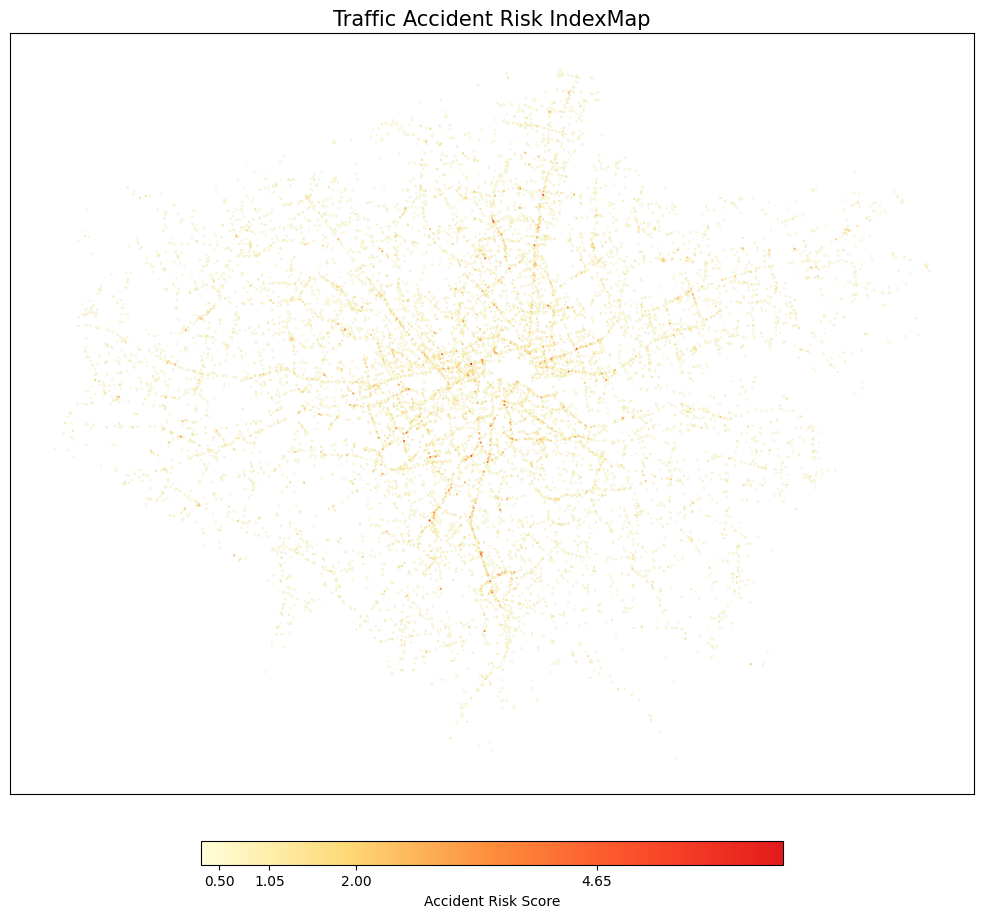

In [13]:
def create_risk_map(
    gdf, 
    risk_column='accident_risk',
    n_classes=5,
    figsize=(10, 10),
    title="Traffic Accident Risk IndexMap",
    save_path=None,
    dpi=300
):
    """
    Create H3 hexagon risk map using Jenks natural breaks classification
    
    Parameters:
        gdf: GeoDataFrame with geometry and risk values
        risk_column: Risk value column name
        n_classes: Number of Jenks classes
        figsize: Figure size
        title: Map title
        save_path: Save path (None = don't save)
        dpi: Image resolution
    
    Returns:
        fig, ax: Matplotlib figure and axis objects
    """
    
    # Set up figure
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate Jenks natural breaks
    risk_values = gdf[gdf[risk_column] > 0][risk_column].values
    if len(risk_values) > 0:
        breaks = jenkspy.jenks_breaks(risk_values, n_classes=n_classes)
        breaks = sorted(set(breaks))
        
        # Create color map with deeper, more vibrant colors
        colors = ['#FFFFD9', '#FED976', '#FD8D3C', '#FC4E2A', '#E31A1C', '#800026'][:len(breaks)]
        cmap = LinearSegmentedColormap.from_list("risk_colors", colors)
        
        # Plot all areas in light gray
        gdf.plot(ax=ax, color='lightgrey', linewidth=0.1)
        
        # Plot risk areas
        gdf[gdf[risk_column] > 0].plot(
            column=risk_column,
            ax=ax,
            cmap=cmap,
            linewidth=0.1,
            legend=False,  # Don't create automatic legend
            vmin=min(breaks),
            vmax=max(breaks)
        )
        
        # Set title and remove axes
        ax.set_title(title, fontsize=15)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add colorbar at the bottom with smaller size
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(breaks), vmax=max(breaks)))
        sm.set_array([])
        
        # Create horizontal colorbar at the bottom
        cbar = plt.colorbar(
            sm, 
            ax=ax, 
            orientation='horizontal',  # Horizontal orientation
            shrink=0.6,                # Make it smaller (50% of width)
            pad=0.05,                  # Padding between map and colorbar
            aspect=25                  # Make it thinner
        )
        
        cbar.set_label('Accident Risk Score', fontsize=10)
        
        # Add labels for the Jenks classes if desired
        if len(breaks) > 1 and n_classes <= 6:  # Only add labels if there aren't too many
            # Calculate positions for the tick marks
            tick_locs = [(breaks[i] + breaks[i+1])/2 for i in range(len(breaks)-1)]
            cbar.set_ticks(tick_locs)
        
        plt.tight_layout()
        
        # Save if path provided
        if save_path:
            plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        
    return fig, ax

# Usage
fig, ax = create_risk_map(h3_features_gdf)
plt.show()

### POI categorisation
For the point-of-interest (POI) analysis, we built upon the method established by Brühwiler et al. (2022), which categorises POIs into five groups: commercial, tourist, nightlife, public, and transportation. Given that the CDRC POI dataset contained 1,572 heterogeneous categories, we implemented a semantic matching algorithm using sentence embeddings and cosine similarity metrics. A matching threshold of 0.4 was applied, with only 2.67% of POIs falling below this threshold (figure 2). Although thresholds between 0.4 and 0.6 occasionally resulted in incorrect matches, the overall approach proved to be a feasible method for consolidating thousands of POI types into five general categories.

This method enabled us to align the diverse POI categories with Google’s standardised 304 subcategories, which are hierarchically structured into 19 primary groups. These 19 categories were then reclassified into the five typological groups defined in our analytical framework. For each H3 hexagonal grid, we calculated the proportional representation of each POI type and applied a six-nearest-neighbour spatial averaging technique to ensure robust spatial characterisation.

[[ go back to the top ]](#Table-of-contents)

In [14]:
df_poi = df_poi.to_crs("EPSG:4326")
london_poi = df_poi[df_poi.geometry.within(london_boundary.geometry.iloc[0])]
main_category_list = london_poi['main_category'].unique()
main_category_list_count = len(main_category_list)
print(main_category_list_count)
main_category_null = london_poi[london_poi['main_category'].isnull()]
main_category_null_count = len(main_category_null)
print(main_category_null_count)
main_category_without_null = london_poi['main_category'].dropna()
main_category_list = main_category_without_null.unique()
main_category_list

1572
47468


array(['pub', 'bed_and_breakfast', 'park', ...,
       'federal_government_offices', 'fish_restaurant',
       'trucks_and_industrial_vehicles'], shape=(1571,), dtype=object)

In [15]:
def map_categories_using_similarity(main_categories, category_mapping_file=None, category_mapping=None, 
                                  model_name='all-mpnet-base-v2', threshold=0.4):
    """
    Map categories to standard categories using sentence embedding and cosine similarity.
    
    Args:
        main_categories: List of categories to match
        category_mapping_file: Path to JSON file with category mapping (optional)
        category_mapping: Dictionary of category mapping (optional, alternative to file)
        model_name: SentenceTransformer model name
        threshold: Similarity threshold for accepting matches
        
    Returns:
        DataFrame with matching results
    """
    import json
    import numpy as np
    import pandas as pd
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Load category mapping
    if category_mapping is None:
        if category_mapping_file is None:
            raise ValueError("Either category_mapping or category_mapping_file must be provided")
        with open(category_mapping_file, 'r') as f:
            category_mapping = json.load(f)
    
    # Build subcategories and reverse mapping
    all_subcategories = []
    reverse_mapping = {}
    for main_category, subcategories in category_mapping.items():
        for subcategory in subcategories:
            all_subcategories.append(subcategory)
            reverse_mapping[subcategory] = main_category
    
    # Load model and generate embeddings
    model = SentenceTransformer(model_name)
    subcategory_embeddings = model.encode(all_subcategories)
    
    # Perform matching
    results = []
    for category in main_categories:
        try:
            # Generate embedding and calculate similarity
            category_embedding = model.encode([category])[0]
            similarities = cosine_similarity([category_embedding], subcategory_embeddings)[0]
            
            # Find best match
            best_match_idx = np.argmax(similarities)
            best_match_subcategory = all_subcategories[best_match_idx]
            similarity_score = similarities[best_match_idx]
            matched_main_category = reverse_mapping[best_match_subcategory]
            
            # Apply threshold
            final_match = matched_main_category if similarity_score >= threshold else "need manual review"
            
            results.append({
                'original_category': category,
                'matched_standard_category': final_match,
                'confidence_score': similarity_score,
                'best_match_subcategory': best_match_subcategory,
            })
        except Exception as e:
            results.append({
                'original_category': category,
                'matched_standard_category': 'error',
                'confidence_score': 0.0,
                'best_match_subcategory': f'error: {str(e)}',
            })
    
    return pd.DataFrame(results)

poi_result = map_categories_using_similarity(main_category_list, category_mapping_file='/Users/tsernian/Documents/CASA/CASA0006_Data Science for Spatial Systems/Assessment/category_mapping.json', category_mapping=None, 
                                  model_name='all-mpnet-base-v2', threshold=0.4)

In [16]:
category_to_type = {
    # Commercial
    'Automotive': 'Commercial',
    'Business': 'Commercial',
    'Finance': 'Commercial',
    'Health and Wellness': 'Commercial',
    'Services': 'Commercial',
    'Shopping': 'Commercial',
    
    # Tourist
    'Culture': 'Tourist',
    'Entertainment and Recreation': 'Tourist',  
    'Lodging': 'Tourist',
    'Natural Features': 'Tourist',
    
    # Nightlife
    'Food and Drink': 'Nightlife',  
    
    # Public
    'Education': 'Public',
    'Facilities': 'Public',
    'Government': 'Public',
    'Sports': 'Public',
    'Places of Worship': 'Public',
    
    # Transportation
    'Transportation': 'Transportation',
    
    # Others
    'Geographical Areas': 'Others',
    'Housing': 'Others'
}

poi_result['5_types'] = poi_result['matched_standard_category'].map(category_to_type)

poi_result['5_types'] = poi_result['5_types'].fillna('Others')
poi_result.head()

original_category     matched_standard_category  confidence_score  \
0                pub                Food and Drink          1.000000   
1  bed_and_breakfast                       Lodging          1.000000   
2               park  Entertainment and Recreation          1.000000   
3         hair_salon                      Services          1.000000   
4    tutoring_center  Entertainment and Recreation          0.595606   

  best_match_subcategory     5_types  
0                    pub   Nightlife  
1      bed_and_breakfast     Tourist  
2                   park     Tourist  
3             hair_salon  Commercial  
4       amusement_center     Tourist

#### figure 2: similarity score distribution
Figure 2 shows a right-skewed distribution of similarity scores, with most values concentrated between 0.5 and 0.8. A small number fall below 0.4, while a significant number score 1.0, indicating an exact match with the standard category.

Text(0, 0.5, 'frequency')

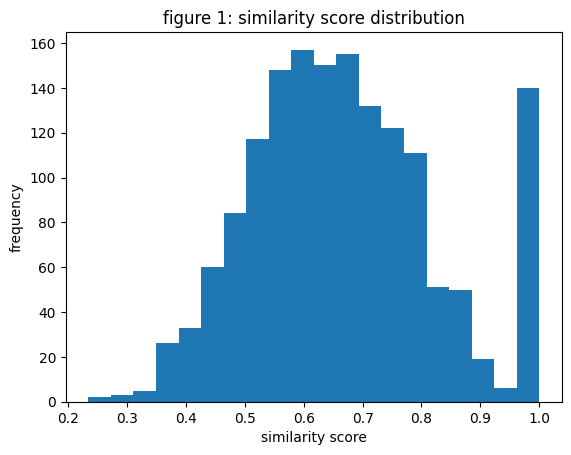

In [17]:
plt.hist(poi_result['confidence_score'], bins=20)
plt.title('figure 1: similarity score distribution')
plt.xlabel('similarity score')
plt.ylabel('frequency')

In [18]:
categories = poi_result['matched_standard_category'].unique()

for category in categories:
    examples = poi_result[poi_result['matched_standard_category'] == category].head(5)
    if len(examples) > 0:
        print(f"\n{category} matches:")
        for _, row in examples.iterrows():
            print(f"  {row['original_category']} > {row['matched_standard_category']} (score: {row['confidence_score']:.4f})")


Food and Drink matches:
  pub > Food and Drink (score: 1.0000)
  chimney_sweep > Food and Drink (score: 0.5682)
  tea_room > Food and Drink (score: 0.8618)
  indian_restaurant > Food and Drink (score: 1.0000)
  sign_making > Food and Drink (score: 0.4577)

Lodging matches:
  bed_and_breakfast > Lodging (score: 1.0000)
  accommodation > Lodging (score: 0.7678)
  home_security > Lodging (score: 0.5632)
  hotel > Lodging (score: 1.0000)
  rv_rentals > Lodging (score: 0.8076)

Entertainment and Recreation matches:
  park > Entertainment and Recreation (score: 1.0000)
  tutoring_center > Entertainment and Recreation (score: 0.5956)
  landmark_and_historical_building > Entertainment and Recreation (score: 0.8433)
  wedding_planning > Entertainment and Recreation (score: 0.7593)
  patio_covers > Entertainment and Recreation (score: 0.5888)

Services matches:
  hair_salon > Services (score: 1.0000)
  beauty_and_spa > Services (score: 0.8169)
  business_management_services > Services (score: 0

In [19]:
london_poi_match = london_poi.merge(poi_result, left_on='main_category', right_on='original_category', how='left')
london_poi_match = london_poi_match[['primary_name','main_category','matched_standard_category','5_types','lat','long','geometry']]
london_poi_match = london_poi_match.dropna(subset=['matched_standard_category'])
london_poi_match = london_poi_match[london_poi_match['5_types'] != 'Others']

In [20]:
# Add H3 indices to POI data if needed
if 'h3_index' not in london_poi_match.columns:
    london_poi_match['h3_index'] = london_poi_match.apply(
        lambda row: h3.latlng_to_cell(float(row['lat']), float(row['long']), 10), 
        axis=1
    )

# Calculate POI type proportions per H3 cell
def calculate_poi_proportions(poi_df):
    # Count total POIs per cell
    h3_totals = poi_df['h3_index'].value_counts().reset_index()
    h3_totals.columns = ['h3_index', 'total_poi_count']
    
    # Count POIs by type per cell
    type_counts = poi_df.groupby(['h3_index', '5_types']).size().reset_index()
    type_counts.columns = ['h3_index', '5_types', 'type_count']
    
    # Calculate proportions
    type_counts = type_counts.merge(h3_totals, on='h3_index')
    #type_counts['proportion'] = type_counts['type_count'] / type_counts['total_poi_count']
    
    # Pivot to wide format for proportions and counts
    #poi_props = type_counts.pivot(index='h3_index', columns='5_types', values='proportion').reset_index()
    poi_counts = type_counts.pivot(index='h3_index', columns='5_types', values='type_count').reset_index()
    
    # Rename count columns to avoid confusion
    count_columns = {col: f'{col}_count' for col in poi_counts.columns if col != 'h3_index'}
    poi_counts = poi_counts.rename(columns=count_columns)
    
    # Merge proportions and counts
    #result = poi_props.merge(poi_counts, on='h3_index')
    
    # Add total POI count
    result = poi_counts.merge(h3_totals, on='h3_index')
    
    return result.fillna(0)

poi_in_h3 = calculate_poi_proportions(london_poi_match)
poi_in_h3 = poi_in_h3.sort_values('total_poi_count', ascending=False)

In [21]:
def apply_neighbor_averaging(h3_features_df, poi_df, h3_column='h3_index'):
    """Apply six-nearest-neighbor averaging to POI data"""
    # Get POI columns to process
    poi_types = [col for col in poi_df.columns if col != h3_column]
    poi_dict = poi_df.set_index(h3_column).to_dict('index')
    
    # Initialize result dataframe
    result_df = h3_features_df.copy()
    for poi_type in poi_types:
        result_df[f'avg_{poi_type}'] = 0.0
    
    # Process each H3 cell
    for idx, row in result_df.iterrows():
        try:
            # Get cell and its 6 neighbors
            neighbors = h3.grid_disk(row[h3_column], 1)
            
            # Calculate averages for each POI type
            for poi_type in poi_types:
                values = [poi_dict.get(n, {}).get(poi_type, 0) for n in neighbors]
                result_df.at[idx, f'avg_{poi_type}'] = np.mean(values) if values else 0
        except:
            continue
    
    # Calculate proportion columns
    for type_name in ['Commercial', 'Tourist', 'Nightlife', 'Public', 'Transportation']:
        result_df[f'{type_name}_prop'] = (
            result_df[f'avg_{type_name}_count'] / result_df['avg_total_poi_count']
        ).fillna(0)
    
    return result_df

In [22]:
# Apply function
h3_features_with_poi = apply_neighbor_averaging(h3_features_gdf, poi_in_h3)
h3_features_with_poi.sort_values('avg_total_poi_count', ascending=False)

h3_index  accident_count  avg_vehicles_per_accident  \
810   8a194ad36aaffff               4                   1.750000   
1353  8a194ad36af7fff               3                   1.666667   
6690  8a194ad36a8ffff               1                   2.000000   
3591  8a194ad3258ffff               2                   2.000000   
531   8a194ad32437fff               4                   2.000000   
...               ...             ...                        ...   
2340  8a194ada354ffff               2                   2.000000   
1521  8a194ad83c4ffff               3                   1.666667   
9630  8a194ad45917fff               1                   1.000000   
5383  8a195dadcd17fff               1                   1.000000   
9557  8a194ad53b47fff               1                   2.000000   

      avg_casualties_per_accident  accident_severity_Slight  \
810                           1.0                       4.0   
1353                          1.0                       3.0   
6690                          1.0                       1.0   
3591                          1.0                       2.0   
531                           1.0                       4.0   
...                           ...                       ...   
2340                          1.0                       1.0   
1521                          1.0                       3.0   
9630                          1.0                       1.0   
5383                          1.0                       0.0   
9557                          2.0                       1.0   

      accident_severity_Serious  accident_severity_Fatal  day_of_week_Sunday  \
810                         0.0                      0.0            0.000000   
1353                        0.0                      0.0            0.333333   
6690                        0.0                      0.0            0.000000   
3591                        0.0                      0.0            0.000000   
531                         0.0                      0.0            0.000000   
...                         ...                      ...                 ...   
2340                        1.0                      0.0            0.500000   
1521                        0.0                      0.0            0.000000   
9630                        0.0                      0.0            0.000000   
5383                        1.0                      0.0            1.000000   
9557                        0.0                      0.0            0.000000   

      day_of_week_Monday  day_of_week_Tuesday  ...  avg_Nightlife_count  \
810             0.000000             0.000000  ...            12.285714   
1353            0.000000             0.000000  ...            11.714286   
6690            0.000000             0.000000  ...            11.000000   
3591            0.000000             0.000000  ...            17.428571   
531             0.000000             0.500000  ...            13.142857   
...                  ...                  ...  ...                  ...   
2340            0.000000             0.000000  ...             0.000000   
1521            0.333333             0.333333  ...             0.000000   
9630            0.000000             1.000000  ...             0.000000   
5383            0.000000             0.000000  ...             0.000000   
9557            0.000000             0.000000  ...             0.000000   

      avg_Public_count  avg_Tourist_count  avg_Transportation_count  \
810          22.142857          42.857143                  2.857143   
1353         21.571429          40.285714                  2.714286   
6690         21.000000          37.142857                  2.571429   
3591         18.714286          36.285714                  1.714286   
531          16.000000          33.571429                  1.000000   
...                ...                ...                       ...   
2340          0.000000           0.000000                  0.000000   
1521     

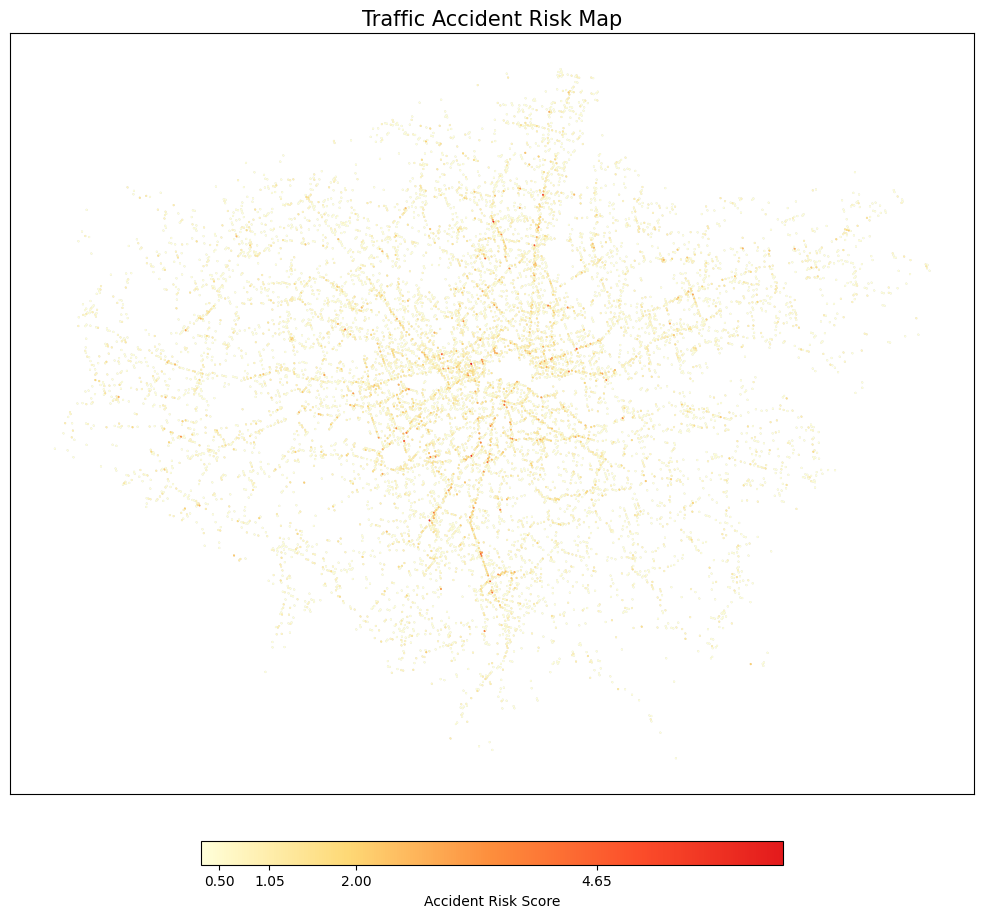

In [23]:
def create_risk_map(
    gdf, 
    risk_column='accident_risk',
    n_classes=5,
    figsize=(10, 10),
    title="Traffic Accident Risk Map",
    save_path=None,
    dpi=300
):
    """
    Create H3 hexagon risk map using Jenks natural breaks classification
    
    Parameters:
        gdf: GeoDataFrame with geometry and risk values
        risk_column: Risk value column name
        n_classes: Number of Jenks classes
        figsize: Figure size
        title: Map title
        save_path: Save path (None = don't save)
        dpi: Image resolution
    
    Returns:
        fig, ax: Matplotlib figure and axis objects
    """
    
    # Set up figure
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate Jenks natural breaks
    risk_values = gdf[gdf[risk_column] > 0][risk_column].values
    if len(risk_values) > 0:
        breaks = jenkspy.jenks_breaks(risk_values, n_classes=n_classes)
        breaks = sorted(set(breaks))
        
        # Create color map with deeper, more vibrant colors
        colors = ['#FFFFD9', '#FED976', '#FD8D3C', '#FC4E2A', '#E31A1C', '#800026'][:len(breaks)]
        cmap = LinearSegmentedColormap.from_list("risk_colors", colors)
        
        # Plot all areas in light gray
        gdf.plot(ax=ax, color='lightgrey', linewidth=0.1)
        
        # Plot risk areas
        gdf[gdf[risk_column] > 0].plot(
            column=risk_column,
            ax=ax,
            cmap=cmap,
            linewidth=0.1,
            legend=False,  # Don't create automatic legend
            vmin=min(breaks),
            vmax=max(breaks)
        )
        
        # Set title and remove axes
        ax.set_title(title, fontsize=15)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Add colorbar at the bottom with smaller size
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(breaks), vmax=max(breaks)))
        sm.set_array([])
        
        # Create horizontal colorbar at the bottom
        cbar = plt.colorbar(
            sm, 
            ax=ax, 
            orientation='horizontal',  # Horizontal orientation
            shrink=0.6,                # Make it smaller (50% of width)
            pad=0.05,                  # Padding between map and colorbar
            aspect=25                  # Make it thinner
        )
        
        cbar.set_label('Accident Risk Score', fontsize=10)
        
        # Add labels for the Jenks classes if desired
        if len(breaks) > 1 and n_classes <= 6:  # Only add labels if there aren't too many
            # Calculate positions for the tick marks
            tick_locs = [(breaks[i] + breaks[i+1])/2 for i in range(len(breaks)-1)]
            cbar.set_ticks(tick_locs)
        
        plt.tight_layout()
        
        # Save if path provided
        if save_path:
            plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        
    return fig, ax

# Usage
fig, ax = create_risk_map(h3_features_gdf)
plt.show()

#### figure 3: categorisation map of POI
From figure 3, we can see the distribution of the 5 categories of POI in London. the commercial, nightlife and tourist POI are mainly concentrated in the central and eastern of London.

In [24]:
# create the color map
unique_categories = london_poi_match['5_types'].unique()
cmap = plt.cm.get_cmap('tab20', len(unique_categories)) 
color_dict = {category: mcolors.rgb2hex(cmap(i)) for i, category in enumerate(unique_categories)}

# create the map
map_poi = folium.Map(location=[51.518, -0.1208], zoom_start=11, tiles='CartoDB positron')

# sample the points
sample_size = min(5000, len(london_poi_match))
london_poi_sample = london_poi_match.sample(sample_size)

# add the points
for idx, row in london_poi_sample.iterrows():
    label_text = f"{row['primary_name']}, {row['main_category']}, {row['matched_standard_category']}, {row['5_types']}"
    
    try:
        lat, lon = float(row['lat']), float(row['long'])
        if -90 <= lat <= 90 and -180 <= lon <= 180:
            folium.CircleMarker(
                location=[lat, lon],
                radius=1,
                color=color_dict[row['5_types']],
                fill=True,
                fill_opacity=0.6,
                tooltip=label_text
            ).add_to(map_poi)
    except (ValueError, TypeError):
        continue

# add the legend
legend_html = '''
<div style="position: fixed; bottom: 50px; right: 50px; z-index: 1000; 
     background-color: white; padding: 10px; border: 1px solid grey;">
  <p><b>category</b></p>
'''
for category, color in color_dict.items():
    legend_html += f'<p><i style="background:{color}; width:10px; height:10px; display:inline-block;"></i> {category}</p>'
legend_html += '</div>'

map_poi.get_root().html.add_child(folium.Element(legend_html))

map_poi

#### table 1: the selected variables for analysis and modelling
| Feature category| category name | description |
|:------------|:-------:|:---------|
| Target varibles| accident risk index | w1 * Death + w2 * Serious + w3 * Slight |
| Accident attributes | number_of_vehicles, number_of_casualties | the number of vehicles and casualties in the accident |
| Temporal attributes| month, day_of_week, time | the month 1-12, day of the week 1-7, time 0-23 |
| Road type| first_road_class, road_type, speed_limit, junction_detail | the first road class, road type, speed limit and junction detail of the road |
| Road conditions| junction_control, road_surface_conditions, pedestrian_crossing_human_control, pedestrian_crossing_physical_facilities, light_conditions | the detial of the road conditions|
| Environmental attributes| weather_conditions | the weather conditions of the accident |
| point of interest| commercial, tourist, nightlife, public, and transportation. | caculate the average number of each type of POI within the neighbourhood of hexagon |

## Methodology
This diagram presents a structured three-phase framework for predicting urban traffic accident risk by integrating advanced spatial analytics with interpretable machine learning. In the first phase, heterogeneous datasets, including road safety and point-of-interest (POI) data, are harmonised into typological categories and spatially processed using H3 hexagonal indexing for consistent geospatial representation.

The modelling phase involves calibrating regression algorithms through cross-validation, with feature selection refined via ShapRFECV, balancing predictive performance and interpretability. Finally, SHAP visualisations enhance model explainability, while external validation confirms generalisability, supporting the model’s applicability in urban traffic safety planning.


![diagram.png](./diagram.png)

#### Compare 3 models (Linear Regression, Random Forest, XGBoost) Performance and hyperparameter tuning
This comparative analysis of regression models for traffic accident risk prediction reveals distinctive performance patterns. Linear Regression demonstrates inadequate predictive capacity (R²≈0.1) across both datasets, confirming the non-linear nature of accident risk factors. Random Forest achieves superior test set accuracy (R²=0.7653) but exhibits substantial overfitting with a 20.31% training-test performance gap. XGBoost emerges as the optimal solution, maintaining strong predictive power (test R²=0.8052) while minimizing the generalisation gap (7.43%). Its conservative parameterisation (learning rate=0.05, max_depth=4) effectively balances complexity with generalisability, making it the recommended model for practical implementation in traffic safety risk prediction across diverse urban environments.

In [25]:
def run_regression_models(df, target_col='accident_risk', exclude_cols=None, test_size=0.25, 
                         random_state=42, tune_hyperparams=True, n_iter=30, save_models=False,
                         models_dir='.', compute_shap=True, n_shap_samples=100):
    """
    Run regression models with train/test performance comparison and SHAP value analysis.
    """
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split, RandomizedSearchCV
    from sklearn.linear_model import LinearRegression
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score
    import xgboost as xgb
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pickle
    import os
    import shap
    
    # Set plotting style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("viridis")
    
    # Set columns to exclude
    if exclude_cols is None:
        exclude_cols = ['geometry', 'h3_index', target_col]
    elif target_col not in exclude_cols:
        exclude_cols.append(target_col)
    
    # Prepare features and target
    X = df[df.columns.difference(exclude_cols)]
    y = df[target_col]
    feature_columns = X.columns.tolist()
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Initialize result containers
    results = {}
    trained_models = {}
    predictions = {'train': {}, 'test': {}}
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr_train = lr.predict(X_train)
    y_pred_lr_test = lr.predict(X_test)
    
    predictions['train']['Linear Regression'] = y_pred_lr_train
    predictions['test']['Linear Regression'] = y_pred_lr_test
    
    # Evaluate Linear Regression
    results['Linear Regression'] = {
        'Train MSE': mean_squared_error(y_train, y_pred_lr_train),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_lr_train)),
        'Train R²': r2_score(y_train, y_pred_lr_train),
        'Test MSE': mean_squared_error(y_test, y_pred_lr_test),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr_test)),
        'Test R²': r2_score(y_test, y_pred_lr_test)
    }
    trained_models['Linear Regression'] = lr
    
    # Hyperparameter tuning for Random Forest and XGBoost
    if tune_hyperparams:
        print("Performing hyperparameter tuning...")
        
        # Random Forest tuning
        rf_param_space = {
            'n_estimators': [50, 100, 150, 200, 300],
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt']
        }
        
        rf_random = RandomizedSearchCV(
            RandomForestRegressor(random_state=random_state),
            param_distributions=rf_param_space,
            n_iter=n_iter, cv=5, scoring='r2', n_jobs=-1,
            random_state=random_state, verbose=1
        )
        rf_random.fit(X_train, y_train)
        best_rf = rf_random.best_estimator_
        
        # XGBoost tuning
        xgb_param_space = {
            'n_estimators': [50, 100, 150, 200, 300], 
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [3, 4, 5, 6, 8],
            'subsample': [0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
        }
        
        xgb_random = RandomizedSearchCV(
            xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state),
            param_distributions=xgb_param_space,
            n_iter=n_iter, cv=5, scoring='r2', n_jobs=-1,
            random_state=random_state, verbose=1
        )
        xgb_random.fit(X_train, y_train)
        best_xgb = xgb_random.best_estimator_
        
        # Print best parameters
        print(f"Best Random Forest Parameters: {rf_random.best_params_}")
        print(f"Best RF CV Score: {rf_random.best_score_:.4f}")
        print(f"Best XGBoost Parameters: {xgb_random.best_params_}")
        print(f"Best XGB CV Score: {xgb_random.best_score_:.4f}")
        
        trained_models['Random Forest'] = best_rf
        trained_models['XGBoost'] = best_xgb
        
    else:
        # Use default models
        best_rf = RandomForestRegressor(n_estimators=100, random_state=random_state)
        best_rf.fit(X_train, y_train)
        trained_models['Random Forest'] = best_rf
        
        best_xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=random_state)
        best_xgb.fit(X_train, y_train)
        trained_models['XGBoost'] = best_xgb
    
    # Evaluate models
    for name, model in [('Random Forest', best_rf), ('XGBoost', best_xgb)]:
        # Predict
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        predictions['train'][name] = y_pred_train
        predictions['test'][name] = y_pred_test
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        train_rmse = np.sqrt(train_mse)
        train_r2 = r2_score(y_train, y_pred_train)
        
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_rmse = np.sqrt(test_mse)
        test_r2 = r2_score(y_test, y_pred_test)
        
        # Store metrics
        results[name] = {
            'Train MSE': train_mse, 'Train RMSE': train_rmse, 'Train R²': train_r2,
            'Test MSE': test_mse, 'Test RMSE': test_rmse, 'Test R²': test_r2
        }
        
        # Print metrics
        print(f"{name}:")
        print(f"  Train - MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
        print(f"  Test  - MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")
        print(f"  Gap - MSE: {train_mse-test_mse:.4f}, R²: {train_r2-test_r2:.4f}")
    
    # Plot model comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Set up data
    models_names = list(results.keys())
    train_r2_vals = [results[model]['Train R²'] for model in models_names]
    test_r2_vals = [results[model]['Test R²'] for model in models_names]
    train_rmse_vals = [results[model]['Train RMSE'] for model in models_names]
    test_rmse_vals = [results[model]['Test RMSE'] for model in models_names]
    
    # Set bar parameters
    bar_width = 0.2
    x = np.arange(len(models_names))
    
    # R² comparison
    axes[0].bar(x - bar_width/2, train_r2_vals, bar_width, color=sns.color_palette("viridis", 3)[0], label='Train')
    axes[0].bar(x + bar_width/2, test_r2_vals, bar_width, color=sns.color_palette("viridis", 3)[1], label='Test')
    axes[0].set_title('R² by Model', fontsize=14)
    axes[0].set_ylabel('R² (higher is better)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models_names)
    axes[0].legend()
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # RMSE comparison
    axes[1].bar(x - bar_width/2, train_rmse_vals, bar_width, color=sns.color_palette("viridis", 3)[0], label='Train')
    axes[1].bar(x + bar_width/2, test_rmse_vals, bar_width, color=sns.color_palette("viridis", 3)[1], label='Test')
    axes[1].set_title('RMSE by Model', fontsize=14)
    axes[1].set_ylabel('RMSE (lower is better)')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models_names)
    axes[1].legend()
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # SHAP Analysis
    shap_values = {}
    if compute_shap:
        print("\nComputing SHAP values and visualizations...")
        
        # For large datasets, use a subset for SHAP analysis
        if n_shap_samples < len(X_test):
            print(f"Using {n_shap_samples} test samples for SHAP analysis (out of {len(X_test)} total)")
            shap_sample_indices = np.random.choice(len(X_test), n_shap_samples, replace=False)
            X_shap = X_test.iloc[shap_sample_indices]
        else:
            X_shap = X_test
        
        # Calculate SHAP values for XGBoost
        if 'XGBoost' in trained_models:
            print("Computing SHAP values for XGBoost...")
            explainer_xgb = shap.Explainer(trained_models['XGBoost'])
            shap_values['XGBoost'] = explainer_xgb(X_shap)
            
            # SHAP summary plot
            plt.figure(figsize=(12, 10))
            plt.title("XGBoost SHAP Summary Plot", fontsize=15)
            shap.summary_plot(shap_values['XGBoost'], X_shap, show=False)
            plt.tight_layout()
            plt.show()           
 
    # Save models
    if save_models:
        if not os.path.exists(models_dir):
            os.makedirs(models_dir)
        with open(os.path.join(models_dir, 'best_rf_model.pkl'), 'wb') as f:
            pickle.dump(best_rf, f)
        with open(os.path.join(models_dir, 'best_xgb_model.pkl'), 'wb') as f:
            pickle.dump(best_xgb, f)
    
    return {
        'models': trained_models,
        'results': pd.DataFrame(results).T,
        'X_train': X_train, 'X_test': X_test,
        'y_train': y_train, 'y_test': y_test,
        'predictions': predictions,
        'shap_values': shap_values if compute_shap else None
    }

Performing hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Random Forest Parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
Best RF CV Score: 0.7656
Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best XGB CV Score: 0.8128
Random Forest:
  Train - MSE: 0.0081, RMSE: 0.0902, R²: 0.9684
  Test  - MSE: 0.0657, RMSE: 0.2564, R²: 0.7653
  Gap - MSE: -0.0576, R²: 0.2031
XGBoost:
  Train - MSE: 0.0310, RMSE: 0.1761, R²: 0.8796
  Test  - MSE: 0.0545, RMSE: 0.2335, R²: 0.8052
  Gap - MSE: -0.0235, R²: 0.0743


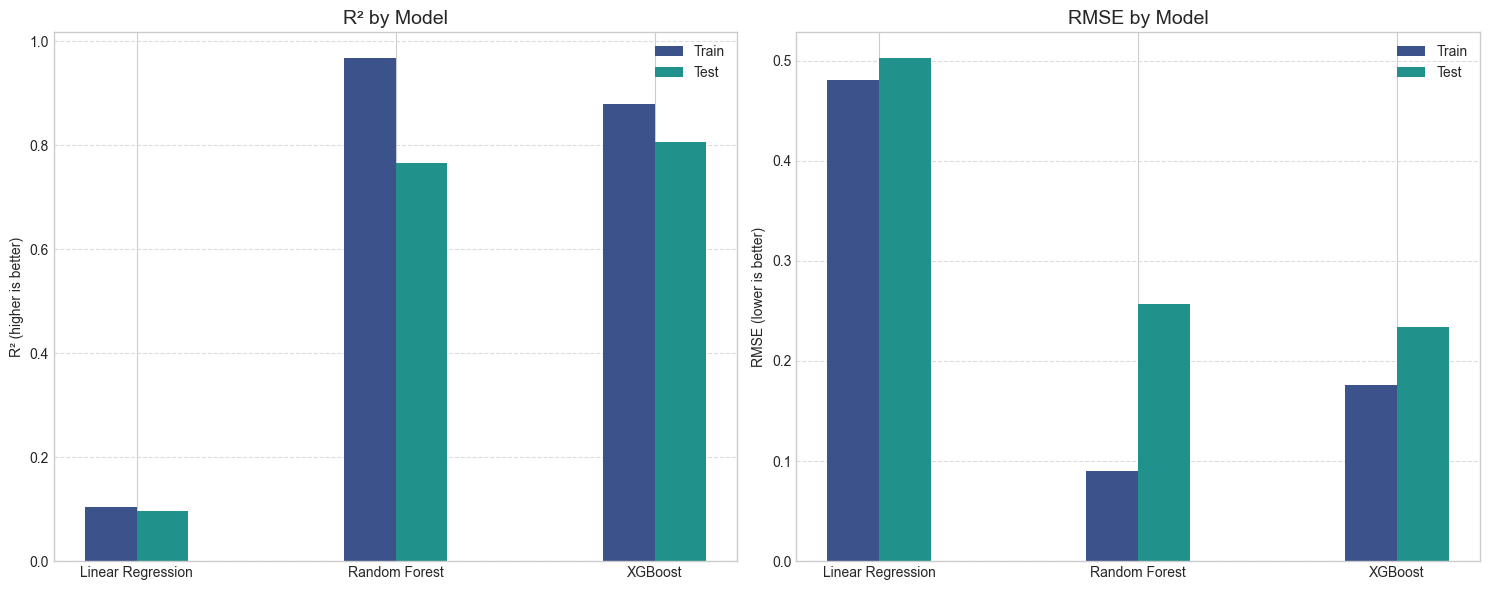

In [26]:
# Usage example:
results = run_regression_models(h3_features_with_poi, 
                                exclude_cols=['geometry', 'h3_index', 'accident_count', 
                                           'accident_severity_Slight', 'accident_severity_Serious', 
                                            'accident_severity_Fatal', 'avg_Commercial_count',
                                            'avg_Nightlife_count', 'avg_Public_count', 'avg_Tourist_count', 
                                            'avg_Transportation_count', 'avg_total_poi_count'],
                                test_size=0.25,
                                random_state=42,
                                tune_hyperparams=True,
                                n_iter=30,
                                save_models=False,
                                models_dir='.',
                                compute_shap=False, 
                                n_shap_samples=100)

#### Recursive feature elimination with cross-validation
The ShapRFECV analysis demonstrates that model performance reaches optimal efficiency with just 14 features in random forest and 16 features in XGBoost, significantly reducing computational complexity whilst maintaining predictive power. This dimensionality reduction produced more parsimonious models, with XGBoost subsequently achieving superior cross-validation scores (R² = 0.8961) and test performance   (R²=0.8054) compared to Random Forest, whilst exhibiting a smaller training-test (gapGap R² = 0.0907), indicating better generalisation capabilities.

#### table 2: the results of feature selection
| Model | Features | Dataset | MSE | RMSE | R² | Gap (R²) |
|:------------|:-------:|:---------:|:-----:|:------:|:-----:|:----------:|
| Random Forest | 14 | Train | 0.0259 | 0.1610 | 0.8993 | 0.1333 |
| Random Forest | 14 | Test | 0.0655 | 0.2559 | 0.7661 | - |
| XGBoost | 16 | Train | 0.0268 | 0.1636 | 0.8961 | 0.0907 |
| XGBoost | 16 | Test | 0.0545 | 0.2334 | 0.8054 | - |

[[ go back to the top ]](#Table-of-contents)

In [27]:
def ShapRFECV_faster(X, y, estimator=None, cv=5, scoring='neg_mean_squared_error', min_features=1, step=5):
    if estimator is None:
        estimator = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
        #{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
    
    features = list(X.columns)
    n_features = len(features)
    
    cv_scores = []
    feature_history = []
    remaining_features = features.copy()
    
    initial_score = np.mean(cross_val_score(
        estimator, X, y, cv=cv, scoring=scoring
    ))
    cv_scores.append(initial_score)
    feature_history.append(remaining_features.copy())
    
    n_iterations = (n_features - min_features) // step + (1 if (n_features - min_features) % step > 0 else 0)
    
    for i in range(n_iterations):
        #train the model and get the shap values
        explainer = shap.Explainer(estimator.fit(X[remaining_features], y))
        shap_values = explainer(X[remaining_features])
        
        #calculate the feature importance
        feature_importance = np.abs(shap_values.values).mean(axis=0)
        feature_importance_dict = dict(zip(remaining_features, feature_importance))
        
        #sort the features by importance
        sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1])
        
        #calculate the number of features to remove
        n_to_remove = min(step, len(remaining_features) - min_features)
        if n_to_remove <= 0:
            break
            
        #remove the least important n_to_remove features
        for j in range(n_to_remove):
            if j < len(sorted_features):
                remaining_features.remove(sorted_features[j][0])
        
        #evaluate the model
        score = np.mean(cross_val_score(
            estimator, X[remaining_features], y, cv=cv, scoring=scoring
        ))
        
        cv_scores.append(score)
        feature_history.append(remaining_features.copy())
    
    #find the best feature combination
    best_idx = np.argmax(cv_scores)
    best_score = cv_scores[best_idx]
    best_features = feature_history[best_idx]
    
    # Visualize results
    plt.figure(figsize=(10, 6))
    feature_counts = [len(fh) for fh in feature_history]
    plt.plot(feature_counts, cv_scores)
    plt.axvline(len(best_features), color='r', linestyle='--')
    plt.xlabel('Number of Features')
    plt.ylabel(f'{scoring} Score')
    plt.title(f'Feature Selection using ShapRFECV\nBest: {len(best_features)} features (score={best_score:.4f})')
    plt.grid()
    plt.show()
    
    return {
        'selected_features': best_features,
        'best_score': best_score,
        'cv_scores': cv_scores,
        'feature_history': feature_history
    }

# Define columns to exclude
exclude_cols = ['geometry', 'h3_index', 'accident_count', 
                'accident_severity_Slight', 'accident_severity_Serious', 
                'accident_severity_Fatal', 'avg_Commercial_count',
                'avg_Nightlife_count', 'avg_Public_count', 'avg_Tourist_count', 
                'avg_Transportation_count', 'avg_total_poi_count',
                'accident_risk']  # Include 'accident_risk'

# Create feature matrix without target variable
X_train_full = h3_features_with_poi.drop(columns=exclude_cols)

# Define target variable separately
y_train = h3_features_with_poi['accident_risk']

# Apply VarianceThreshold to reduce features
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold as needed
selector.fit(X_train_full)

# Get names of features to keep
kept_features_mask = selector.get_support()
kept_features = X_train_full.columns[kept_features_mask].tolist()

print(f"Original feature count: {X_train_full.shape[1]}")
print(f"Features after variance filtering: {len(kept_features)}")
print(f"Removed {X_train_full.shape[1] - len(kept_features)} low variance features")

# Create reduced feature set
X_reduced = X_train_full[kept_features]

# Option 1: Use ShapRFECV for further feature selection
if len(kept_features) > 20:  # Only use ShapRFECV if we still have many features
    try:
        print("Applying ShapRFECV for further feature selection...")
        results = ShapRFECV_faster(X_reduced, y_train, cv=3, step=3, min_features=10)
        final_features = results['selected_features']
        print(f"Final selected features using ShapRFECV: {len(final_features)}")
        print(final_features)
    except Exception as e:
        print(f"Error in ShapRFECV: {e}")
        print("Using variance threshold features instead")
        final_features = kept_features
else:
    # Option 2: Just use VarianceThreshold results if few features remain
    print("Few features remain after variance threshold, skipping ShapRFECV")
    final_features = kept_features
    
print(f"Final selected feature count: {len(final_features)}")

Original feature count: 106
Features after variance filtering: 86
Removed 20 low variance features
Applying ShapRFECV for further feature selection...
Error in ShapRFECV: name 'shap' is not defined
Using variance threshold features instead
Final selected feature count: 86


Performing hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Random Forest Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Best RF CV Score: 0.7653
Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best XGB CV Score: 0.7905
Random Forest:
  Train - MSE: 0.0259, RMSE: 0.1610, R²: 0.8993
  Test  - MSE: 0.0655, RMSE: 0.2559, R²: 0.7661
  Gap - MSE: -0.0396, R²: 0.1333
XGBoost:
  Train - MSE: 0.0296, RMSE: 0.1720, R²: 0.8851
  Test  - MSE: 0.0585, RMSE: 0.2418, R²: 0.7911
  Gap - MSE: -0.0289, R²: 0.0940


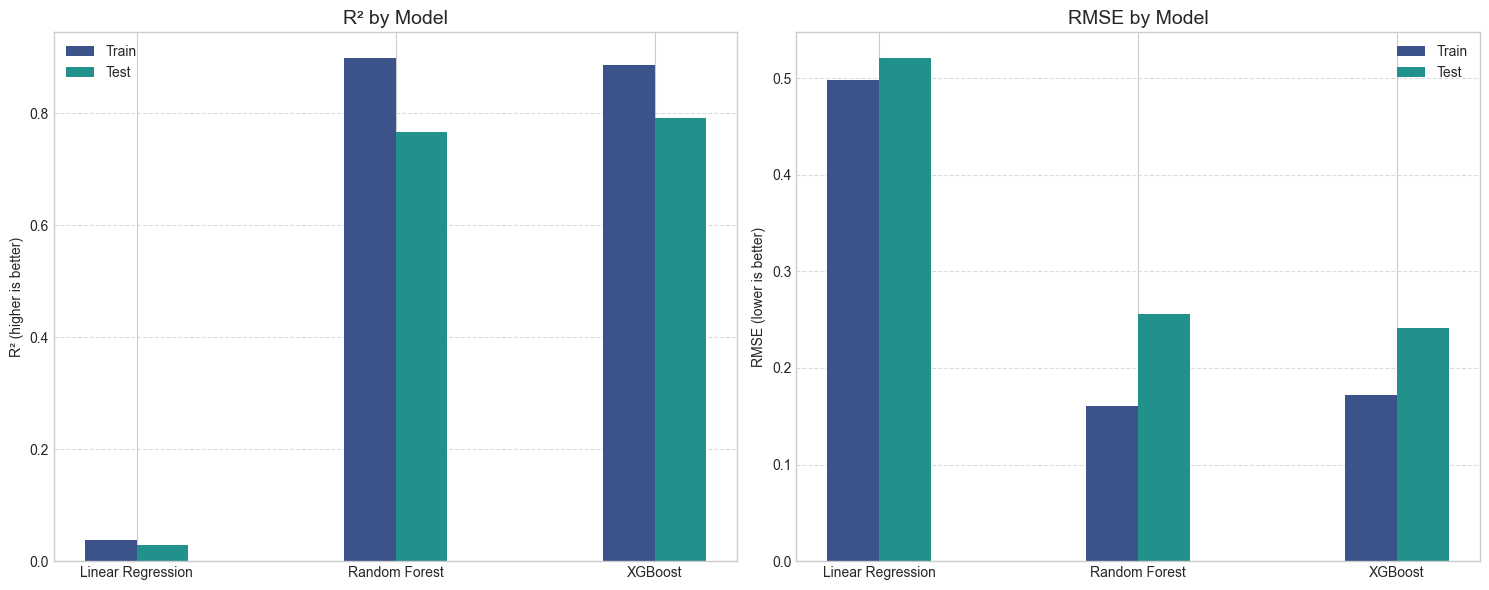

In [28]:
h3_features_with_poi_shap_rf = h3_features_with_poi[['accident_risk', 'avg_vehicles_per_accident', 
                             'day_of_week_Wednesday', 'day_of_week_Thursday', 
                             'day_of_week_Friday', 'road_type_Dual_carriageway', 
                             'junction_detail_T_or_staggered_junction', 
                             'junction_control_Give_way_or_uncontrolled', 
                             'road_surface_conditions_Dry', 'light_conditions_Darkness___lights_lit', 
                             'light_conditions_Daylight', 'weather_conditions_Fine_no_high_winds', 
                             'pedestrian_crossing_human_control_None_within_50_metres_', 
                             'pedestrian_crossing_physical_facilities_Pedestrian_phase_at_traffic_signal_junction', 
                             'pedestrian_crossing_physical_facilities_unknown_self_reported']]

results = run_regression_models(h3_features_with_poi_shap_rf, 
                                exclude_cols=['geometry', 'h3_index', 'accident_count', 
                                           'accident_severity_Slight', 'accident_severity_Serious', 
                                            'accident_severity_Fatal', 'avg_Commercial_count',
                                            'avg_Nightlife_count', 'avg_Public_count', 'avg_Tourist_count', 
                                            'avg_Transportation_count', 'avg_total_poi_count'],
                                test_size=0.25,
                                random_state=42,
                                tune_hyperparams=True,
                                n_iter=30,
                                save_models=False,
                                models_dir='.',
                                compute_shap=False, 
                                n_shap_samples=100)

In [29]:
def ShapRFECV_faster(X, y, estimator=None, cv=5, scoring='neg_mean_squared_error', min_features=1, step=5):
    if estimator is None:
        xgb_params = {'n_estimators': 150,'max_depth': 8,'learning_rate': 0.1,'subsample': 0.8,'colsample_bytree': 0.8,'gamma': 0,'reg_alpha': 0,'reg_lambda': 1}
        estimator = xgb.XGBRegressor(**xgb_params)
    
    features = list(X.columns)
    n_features = len(features)
    
    cv_scores = []
    feature_history = []
    remaining_features = features.copy()
    
    initial_score = np.mean(cross_val_score(
        estimator, X, y, cv=cv, scoring=scoring
    ))
    cv_scores.append(initial_score)
    feature_history.append(remaining_features.copy())
    
    n_iterations = (n_features - min_features) // step + (1 if (n_features - min_features) % step > 0 else 0)
    
    for i in range(n_iterations):
        #train the model and get the shap values
        explainer = shap.Explainer(estimator.fit(X[remaining_features], y))
        shap_values = explainer(X[remaining_features])
        
        #calculate the feature importance
        feature_importance = np.abs(shap_values.values).mean(axis=0)
        feature_importance_dict = dict(zip(remaining_features, feature_importance))
        
        #sort the features by importance
        sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1])
        
        #calculate the number of features to remove
        n_to_remove = min(step, len(remaining_features) - min_features)
        if n_to_remove <= 0:
            break
            
        #remove the least important n_to_remove features
        for j in range(n_to_remove):
            if j < len(sorted_features):
                remaining_features.remove(sorted_features[j][0])
        
        #evaluate the model
        score = np.mean(cross_val_score(
            estimator, X[remaining_features], y, cv=cv, scoring=scoring
        ))
        
        cv_scores.append(score)
        feature_history.append(remaining_features.copy())
    
    #find the best feature combination
    best_idx = np.argmax(cv_scores)
    best_score = cv_scores[best_idx]
    best_features = feature_history[best_idx]
    
    # Visualize results
    plt.figure(figsize=(10, 6))
    feature_counts = [len(fh) for fh in feature_history]
    plt.plot(feature_counts, cv_scores)
    plt.axvline(len(best_features), color='r', linestyle='--')
    plt.xlabel('Number of Features')
    plt.ylabel(f'{scoring} Score')
    plt.title(f'Feature Selection using ShapRFECV\nBest: {len(best_features)} features (score={best_score:.4f})')
    plt.grid()
    plt.show()
    
    return {
        'selected_features': best_features,
        'best_score': best_score,
        'cv_scores': cv_scores,
        'feature_history': feature_history
    }

# Define columns to exclude
exclude_cols = ['geometry', 'h3_index', 'accident_count', 
                'accident_severity_Slight', 'accident_severity_Serious', 
                'accident_severity_Fatal', 'avg_Commercial_count',
                'avg_Nightlife_count', 'avg_Public_count', 'avg_Tourist_count', 
                'avg_Transportation_count', 'avg_total_poi_count',
                'accident_risk'] 

# Create feature matrix without target variable
X_train_full = h3_features_with_poi.drop(columns=exclude_cols)

# Define target variable separately
y_train = h3_features_with_poi['accident_risk']

# Apply VarianceThreshold to reduce features
selector = VarianceThreshold(threshold=0)  # Adjust threshold as needed
selector.fit(X_train_full)

# Get names of features to keep
kept_features_mask = selector.get_support()
kept_features = X_train_full.columns[kept_features_mask].tolist()

print(f"Original feature count: {X_train_full.shape[1]}")
print(f"Features after variance filtering: {len(kept_features)}")
print(f"Removed {X_train_full.shape[1] - len(kept_features)} low variance features")

# Create reduced feature set
X_reduced = X_train_full[kept_features]


xgb_params = {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
estimator = xgb.XGBRegressor(**xgb_params)

# Option 1: Use ShapRFECV for further feature selection
if len(kept_features) > 20:
    try:
        print("Applying ShapRFECV for further feature selection...")
        results = ShapRFECV_faster(X_reduced, y_train, estimator=estimator, cv=3, step=2, min_features=10)
        final_features = results['selected_features']
        print(f"Final selected features using ShapRFECV: {len(final_features)}")
        print(final_features)
    except Exception as e:
        print(f"Error in ShapRFECV: {e}")
        print("Using variance threshold features instead")
        final_features = kept_features
else:
    # Option 2: Just use VarianceThreshold results if few features remain
    print("Few features remain after variance threshold, skipping ShapRFECV")
    final_features = kept_features
    
print(f"Final selected feature count: {len(final_features)}")

Original feature count: 106
Features after variance filtering: 106
Removed 0 low variance features
Applying ShapRFECV for further feature selection...
Error in ShapRFECV: name 'shap' is not defined
Using variance threshold features instead
Final selected feature count: 106


## Results and discussion

[[ go back to the top ]](#Table-of-contents)

#### SHAP Value Analysis of Traffic Accident Risk Factors
This SHAP beeswarm plot visualises the influence of various features on traffic accident risk prediction. Features are ranked by importance from top to bottom, with pedestrian crossing facilities at traffic signals exhibiting the highest impact. The horizontal axis represents the SHAP value (influence on the prediction), where positive values indicate an increase in predicted risk, and negative values indicate a decrease. Colour coding reflects feature values (red = high, blue = low). Notably, POI data is not included in the plot, suggesting it either has a relatively low impact on accident risk or that other variables are more strongly correlated and thus dominate the prediction.

Notably, high presence of pedestrian phases at traffic signals (red points) shows divergent effects, while darkness with street lighting consistently increases risk. Higher average vehicles per accident strongly correlates with increased risk prediction. Temporal patterns reveal weekdays and Saturday having stronger positive impacts than Sunday. Road characteristics show that T-junctions and absence of pedestrian control within 50 meters (red points) generally increase risk predictions, while dual carriageways display varied effects depending on specific conditions.

This analysis highlights key factors influencing traffic accident risk predictions, particularly pedestrian signal infrastructure, lighting conditions, road types, and temporal patterns. Pedestrian phases at traffic signals, darkness with street lighting, and weekday occurrences are all associated with elevated risk.

Performing hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Random Forest Parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}
Best RF CV Score: 0.7799
Best XGBoost Parameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best XGB CV Score: 0.8045
Random Forest:
  Train - MSE: 0.0291, RMSE: 0.1706, R²: 0.8869
  Test  - MSE: 0.0608, RMSE: 0.2465, R²: 0.7830
  Gap - MSE: -0.0317, R²: 0.1039
XGBoost:
  Train - MSE: 0.0268, RMSE: 0.1636, R²: 0.8961
  Test  - MSE: 0.0545, RMSE: 0.2334, R²: 0.8054
  Gap - MSE: -0.0277, R²: 0.0907


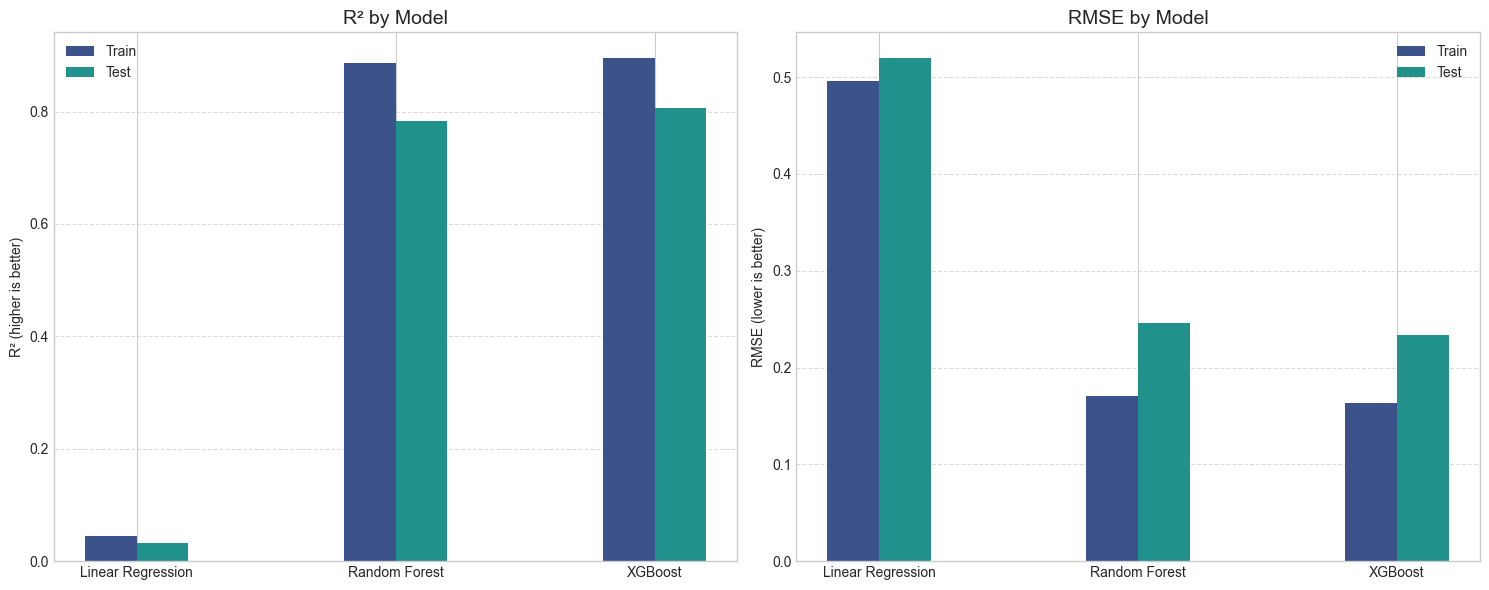


Computing SHAP values and visualizations...
Computing SHAP values for XGBoost...


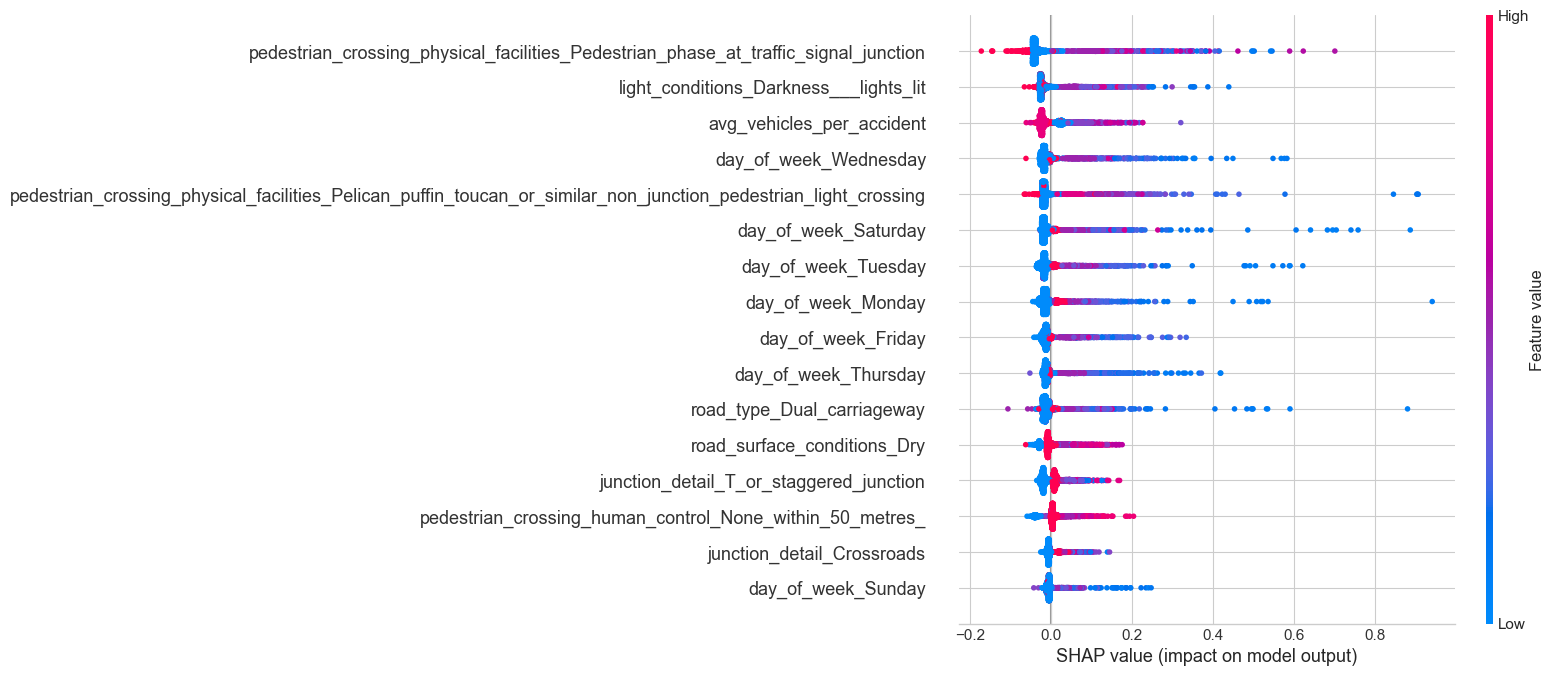

In [30]:
h3_features_with_poi_shap_xg = h3_features_with_poi[['accident_risk', 'avg_vehicles_per_accident', 'day_of_week_Sunday', 'day_of_week_Monday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'day_of_week_Thursday', 'day_of_week_Friday', 'day_of_week_Saturday', 'road_type_Dual_carriageway', 'junction_detail_T_or_staggered_junction', 'junction_detail_Crossroads', 'road_surface_conditions_Dry', 'light_conditions_Darkness___lights_lit', 'pedestrian_crossing_human_control_None_within_50_metres_', 'pedestrian_crossing_physical_facilities_Pedestrian_phase_at_traffic_signal_junction', 'pedestrian_crossing_physical_facilities_Pelican_puffin_toucan_or_similar_non_junction_pedestrian_light_crossing']]

results = run_regression_models(h3_features_with_poi_shap_xg, 
                                exclude_cols=['geometry', 'h3_index', 'accident_count', 
                                           'accident_severity_Slight', 'accident_severity_Serious', 
                                            'accident_severity_Fatal', 'avg_Commercial_count',
                                            'avg_Nightlife_count', 'avg_Public_count', 'avg_Tourist_count', 
                                            'avg_Transportation_count', 'avg_total_poi_count'],
                                test_size=0.25,
                                random_state=42,
                                tune_hyperparams=True,
                                n_iter=30,
                                save_models=True,
                                models_dir='/Users/tsernian/Documents/CASA/CASA0006_Data Science for Spatial Systems/Assessment/models',
                                compute_shap=True, 
                                n_shap_samples=2675)

#### Let's try to use our models predict the accident risk for other cities
The modelling results demonstrate a stark contrast between the two cities' predictive performance. Birmingham's models exhibit substantially better performance, with R² scores of approximately 0.665, indicating that XGBoost explains roughly 67% of the variance in the data. In contrast, Manchester's models show rather poor performance, with R² scores of merely 0.19, suggesting limited predictive capability.

#### table 3: the results of predicting the accident risk for other cities
| city | model | R² Score | MSE | RMSE | Mean Absolute Error |
|:------------|:-------:|:---------:|:-----:|:------:|:-----:|
| Manchester | XGBoost | 0.1881 | 0.044074 | 0.209938 | 0.162595 |
| Birmingham | XGBoost | 0.6645 | 0.037324 | 0.193195 | 0.142996 |

In [31]:
def process_city_collision_data(city_name, df_collision, model_features, guide_df, h3_resolution=10):
    """
    Process traffic collision data for a specified city and create H3 spatial index features
    
    Parameters:
        city_name (str): City name, e.g. "Manchester, UK"
        df_collision (GeoDataFrame): GeoDataFrame containing traffic collision data
        model_features (list): List of features to select
        guide_df (DataFrame): Feature mapping reference data
        h3_resolution (int): H3 grid resolution, default is 10
        
    Returns:
        GeoDataFrame: Processed H3 grid data
        dict: Data processing statistics
    """
    import geopandas as gpd
    from shapely.geometry import shape
    from geopandas import GeoDataFrame
    import osmnx as ox
    
    # Get city boundary
    city_boundary = ox.geocode_to_gdf(city_name)
    
    # Filter collisions within city boundary
    city_collision = df_collision[df_collision.geometry.within(city_boundary.geometry.iloc[0])]
    city_collision_new = city_collision[model_features]
    original_count = len(city_collision_new)
    
    # Identify and remove missing values
    missing_condition = False
    for col in city_collision_new.columns:
        missing_condition = missing_condition | (city_collision_new[col] == -1)
    
    city_collision_clean = city_collision_new[~missing_condition]
    dropped_count = original_count - len(city_collision_clean)
    
    # Create H3 features
    city_h3 = create_h3_features(city_collision_clean, h3_resolution=h3_resolution, 
                                categorical_columns=None, guide_df=guide_df)
    
    # Calculate accident risk score
    city_h3['accident_risk'] = (city_h3['accident_severity_Slight']*0.3 + 
                               city_h3['accident_severity_Serious']*0.7 + 
                               city_h3['accident_severity_Fatal']*1)
    
    city_h3 = city_h3.sort_values('accident_risk', ascending=False)
    
    # Create GeoDataFrame
    city_h3_gdf = GeoDataFrame(city_h3, geometry=city_h3['geometry'].apply(shape), crs="EPSG:4326")
    
    # Compile statistics
    stats = {
        "original_rows": original_count,
        "dropped_rows": dropped_count,
        "drop_percentage": dropped_count/original_count if original_count > 0 else 0,
        "remaining_rows": len(city_collision_clean),
        "h3_cell_count": len(city_h3),
        "feature_count": len(city_h3.columns)
    }
    
    # Display processing statistics
    print(f"Processing collision data for {city_name}:")
    print(f"Original row count: {stats['original_rows']}")
    print(f"Rows with missing values dropped: {stats['dropped_rows']} ({stats['drop_percentage']:.2%})")
    print(f"Remaining rows: {stats['remaining_rows']}")
    print(f"Total H3 cells: {stats['h3_cell_count']}")
    print(f"Feature count: {stats['feature_count']}")
    
    return city_h3_gdf, stats

In [32]:
# Process Manchester data using the function
manchester_h3_gdf, manchester_stats = process_city_collision_data(
    city_name="Greater Manchester, UK",
    df_collision=df_collision,
    model_features=model_features,
    guide_df=new_guide,
    h3_resolution=10
)

Processing collision data for Greater Manchester, UK:
Original row count: 2530
Rows with missing values dropped: 1456 (57.55%)
Remaining rows: 1074
Total H3 cells: 978
Feature count: 102


In [33]:
birmingham_h3_gdf, birmingham_stats = process_city_collision_data(
    city_name="Birmingham, UK",
    df_collision=df_collision,
    model_features=model_features,
    guide_df=new_guide,
    h3_resolution=10
)

Processing collision data for Birmingham, UK:
Original row count: 2200
Rows with missing values dropped: 764 (34.73%)
Remaining rows: 1436
Total H3 cells: 1069
Feature count: 102


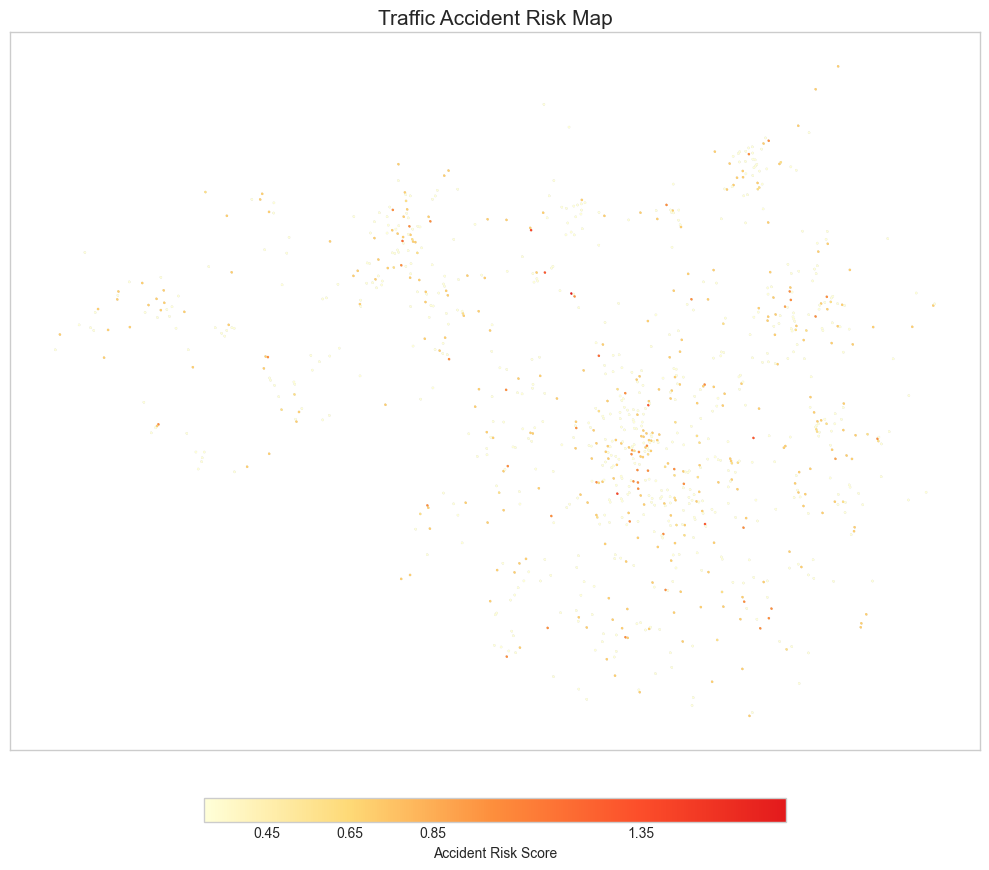

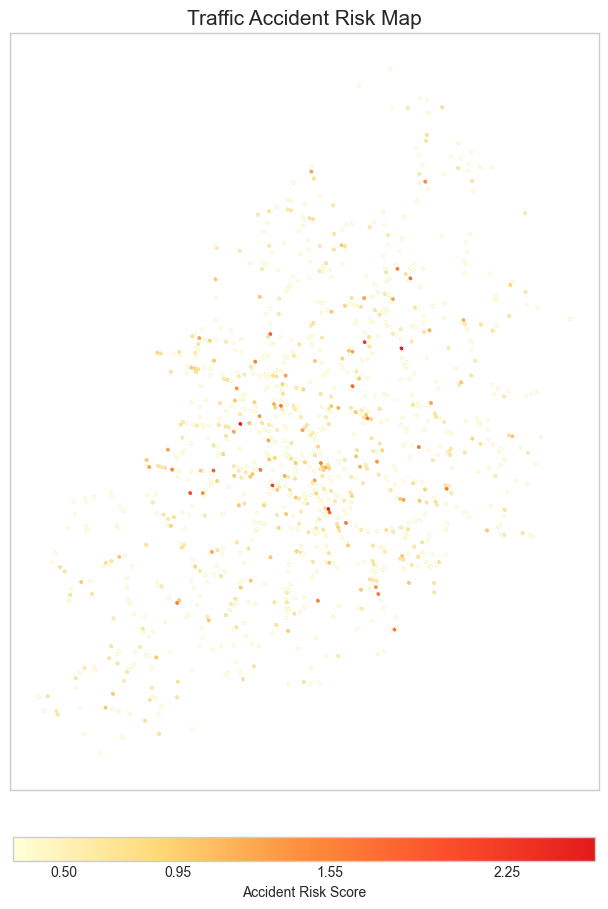

In [34]:
fig, ax = create_risk_map(manchester_h3_gdf)
#plt.show()
fig, ax = create_risk_map(birmingham_h3_gdf)
#plt.show()

In [35]:
def predict_with_models(new_data, models=None, model_paths=None, exclude_cols=None, 
                        
                       feature_columns=None, save_predictions=False, output_file='predictions.csv'):
    """Make predictions and calculate error metrics (absolute error, R², MSE)."""
    import pandas as pd
    import numpy as np
    import pickle
    import os
    from sklearn.metrics import r2_score, mean_squared_error
    
    if models is None and model_paths is None:
        raise ValueError("Must provide either models or model_paths")
    
    # Default exclude columns
    if exclude_cols is None:
        exclude_cols = ['geometry', 'h3_index', 'accident_risk', 'accident_count', 
                       'accident_severity_Fatal', 'accident_severity_Serious', 
                       'accident_severity_Slight']
    
    # Save actual risk values
    actual_risk = new_data['accident_risk'].copy() if 'accident_risk' in new_data.columns else None
    
    # Prepare features
    X_new = new_data.drop(columns=[col for col in exclude_cols if col in new_data.columns])
    
    # Load models if needed
    if models is None:
        models = {name: pickle.load(open(path, 'rb')) for name, path in model_paths.items()}
    
    # Get feature columns from model if not provided
    if feature_columns is None and models:
        model = next(iter(models.values()))
        feature_columns = getattr(model, 'feature_names_in_', None)
    
    # Align feature columns with model expectations
    if feature_columns is not None:
        for col in feature_columns:
            if col not in X_new.columns:
                X_new[col] = 0
        X_new = X_new[feature_columns]
    
    # Make predictions
    results = pd.DataFrame({f'{name} Prediction': model.predict(X_new) 
                          for name, model in models.items()})
    
    # Add h3_index if available
    if 'h3_index' in new_data.columns:
        results['h3_index'] = new_data['h3_index'].values
    
    # Add actual values and calculate error metrics
    metrics = {}
    if actual_risk is not None:
        results['accident_risk'] = actual_risk.values
        for name in models.keys():
            # Absolute error
            results[f'|error|_{name}'] = np.abs(results['accident_risk'] - results[f'{name} Prediction'])
            
            # Calculate R² and MSE
            y_true = results['accident_risk']
            y_pred = results[f'{name} Prediction']
            
            r2 = r2_score(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            
            # Store metrics
            metrics[name] = {
                'R²': r2,
                'MSE': mse,
                'RMSE': rmse,
                'MAE': results[f'|error|_{name}'].mean()
            }
            
            print(f"Model: {name}")
            print(f"  R² Score: {r2:.4f}")
            print(f"  MSE: {mse:.6f}")
            print(f"  RMSE: {rmse:.6f}")
            print(f"  Mean Absolute Error: {results[f'|error|_{name}'].mean():.6f}")
            print("------------------------------")
    
    # Save if requested
    if save_predictions:
        results.to_csv(output_file, index=False)
    
    return results, metrics

results_df, metrics = predict_with_models(
    new_data=manchester_h3_gdf,
    model_paths={
        'Random Forest': 'models/best_rf_model.pkl',
        'XGBoost': 'models/best_xgb_model.pkl'
    },
    exclude_cols=None,
    save_predictions=False,
    output_file='model_predictions.csv'
)
results_df

Model: Random Forest
  R² Score: 0.1990
  MSE: 0.043482
  RMSE: 0.208524
  Mean Absolute Error: 0.166083
------------------------------
Model: XGBoost
  R² Score: 0.1881
  MSE: 0.044074
  RMSE: 0.209938
  Mean Absolute Error: 0.162595
------------------------------


Random Forest Prediction  XGBoost Prediction         h3_index  \
0                    0.719881            0.651908  8a1951b2126ffff   
1                    0.804760            0.780002  8a1951b73b37fff   
2                    0.696504            0.761940  8a1951b20117fff   
3                    1.072787            1.136235  8a1951b630b7fff   
4                    0.973985            0.856438  8a1951b64877fff   
..                        ...                 ...              ...   
973                  0.380389            0.367321  8a1951b5c2c7fff   
974                  0.375970            0.382620  8a1951bb3257fff   
975                  0.377546            0.370803  8a1951b4eb67fff   
976                  0.391514            0.387844  8a1951b0d1affff   
977                  0.437163            0.442591  8a19424c2caffff   

     accident_risk  |error|_Random Forest  |error|_XGBoost  
0              1.7               0.980119         1.048092  
1              1.4               0.595240         0.619998  
2              1.4               0.703496         0.638060  
3              1.3               0.227213         0.163765  
4              1.3               0.326015         0.443562  
..             ...                    ...              ...  
973            0.3               0.080389         0.067321  
974            0.3               0.075970         0.082620  
975            0.3               0.077546         0.070803  
976            0.3               0.091514         0.087844  
977            0.3               0.137163         0.142591  

[978 rows x 6 columns]

In [36]:
results_df, metrics = predict_with_models(
    new_data=birmingham_h3_gdf,
    model_paths={
        'Random Forest': 'models/best_rf_model.pkl',
        'XGBoost': 'models/best_xgb_model.pkl'
    },
    exclude_cols=None,
    save_predictions=False,
    output_file='model_predictions.csv'
)
results_df

Model: Random Forest
  R² Score: 0.6711
  MSE: 0.036589
  RMSE: 0.191282
  Mean Absolute Error: 0.146097
------------------------------
Model: XGBoost
  R² Score: 0.6645
  MSE: 0.037324
  RMSE: 0.193195
  Mean Absolute Error: 0.142996
------------------------------


Random Forest Prediction  XGBoost Prediction         h3_index  \
0                     1.644961            1.988197  8a195c3a445ffff   
1                     1.527998            1.646999  8a195c05bd2ffff   
2                     1.820588            1.909811  8a195c041657fff   
3                     1.553710            1.773741  8a195c3a6c17fff   
4                     1.795659            1.775212  8a195c043327fff   
...                        ...                 ...              ...   
1064                  0.404804            0.379145  8a195c05c577fff   
1065                  0.416468            0.442056  8a195c386777fff   
1066                  0.355408            0.367094  8a195c0667affff   
1067                  0.364670            0.351350  8a195c05872ffff   
1068                  0.429521            0.454104  8a195c39c487fff   

      accident_risk  |error|_Random Forest  |error|_XGBoost  
0               2.6               0.955039         0.611803  
1               2.6               1.072002         0.953001  
2               2.6               0.779412         0.690189  
3               2.3               0.746290         0.526259  
4               2.3               0.504341         0.524788  
...             ...                    ...              ...  
1064            0.3               0.104804         0.079145  
1065            0.3               0.116468         0.142056  
1066            0.3               0.055408         0.067094  
1067            0.3               0.064670         0.051350  
1068            0.3               0.129521         0.154104  

[1069 rows x 6 columns]

In [39]:
from datetime import datetime
notebook_end_time = datetime.now()
duration = notebook_end_time - notebook_start_time
hours = duration.total_seconds()

print(f"Notebook execution completed at: {notebook_end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total runtime: {hours:.2f} seconds")
print(f"\nHardware Specifications:")
print(f"- CPU: Apple M3 Pro (12 cores)")
print(f"- Memory: 32GB unified memory")
print(f"- OS: macOS Sonoma 14.X")

Notebook execution completed at: 2025-04-21 22:07:01
Total runtime: 143.33 seconds

Hardware Specifications:
- CPU: Apple M3 Pro (12 cores)
- Memory: 32GB unified memory
- OS: macOS Sonoma 14.X


## Conclusion
In conclusion, our analysis addresses the three research questions as follows: SHAP analysis identifies key factors influencing accident severity in London as pedestrian crossings at traffic signals, lighting conditions (notably darkness with street lighting), and temporal patterns, with higher risk on weekdays. This underscores the importance of infrastructure and environmental conditions, though the best-performing model was not specified. POI features were absent from the SHAP beeswarm plot, suggesting limited influence or overshadowing by stronger variables—warranting further investigation. Model generalisability varies significantly across cities: it performs well in Birmingham (R² ≈ 0.67) but poorly in Manchester (R² ≈ 0.19), indicating that local context critically affects model transferability. These findings highlight both the strengths and limitations of accident severity prediction models, showing that while certain factors are consistently important, broader applicability across different urban areas remains a challenge. Further refinement is needed to enhance the robustness and generalisability of such models.

[[ go back to the top ]](#Table-of-contents)

## References
Ahmed, S., Hossain, M.A., Ray, S.K., Bhuiyan, M.M.I., & Sabuj, S.R. (2023). A study on road accident prediction and contributing factors using explainable machine learning models: analysis and performance. Transportation Research Interdisciplinary Perspectives, 19, 100814. https://doi.org/10.1016/j.trip.2023.100814

Brühwiler, L., Fu, C., Huang, H., Longhi, L., & Weibel, R. (2022). Predicting individuals’ car accident risk by trajectory, driving events, and geographical context. Computers, Environment and Urban Systems, 93, 101760. https://doi.org/10.1016/j.compenvurbsys.2022.101760

Rifat, M.A.K., Kabir, A., & Huq, A. (2024). An explainable machine learning approach to traffic accident fatality prediction. Procedia Computer Science, 246, 1905–1914. https://doi.org/10.1016/j.procs.2024.09.704

[[ go back to the top ]](#Table-of-contents)